# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [272]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import hashlib
import os
import pickle
from urllib.request import urlretrieve
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import cv2
from matplotlib import gridspec
import math
import tensorflow as tf
import random
from random import sample
import math
from tensorflow.contrib.layers import flatten
import time
import datetime
from datetime import timedelta
from sklearn.metrics import confusion_matrix
#from utils5 import *

---
## Step 0: Load The Data

In [273]:
# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [274]:
### Replace each question mark with the appropriate value.

### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: number of training examples
n_train_label = len(y_train)

# TODO: number of testing examples
n_test_label = len(y_test)

# TODO: what's the shape of an image?
train_image_shape = X_train.shape
test_image_shape = X_test.shape
train_label_shape = y_train.shape
test_label_shape = y_test.shape

# TODO: how many classes are in the dataset
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of training labels =", n_train_label)
print("Number of testing labels =", n_test_label)
print("Training image data shape =", train_image_shape)
print("Testing image data shape =", test_image_shape)
print("Training label data shape =", train_label_shape)
print("Testing label data shape =", test_label_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Number of training labels = 39209
Number of testing labels = 12630
Training image data shape = (39209, 32, 32, 3)
Testing image data shape = (12630, 32, 32, 3)
Training label data shape = (39209,)
Testing label data shape = (12630,)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Sample test images: 100%|██████████| 43/43 [00:16<00:00,  3.12labels/s]


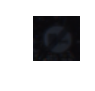

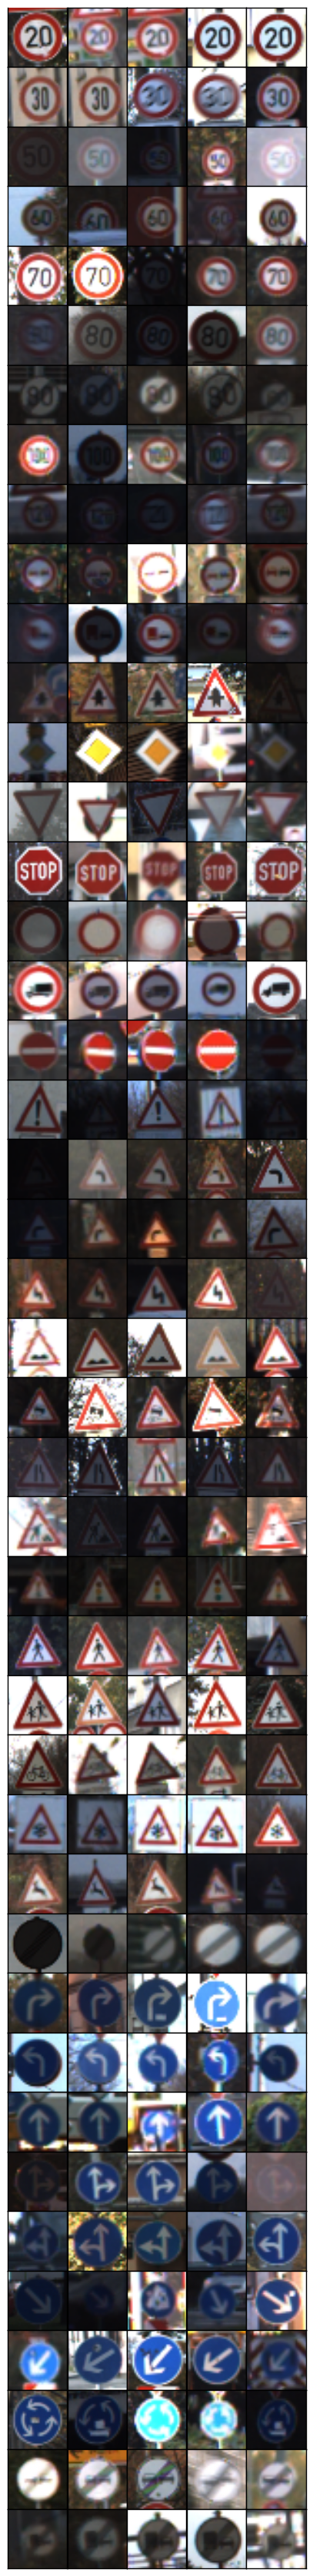

In [275]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
### Plot the input images

def plot_input_images():
    sample_size = 5 #five images per class label
    count = 1 #book keeping for plots
    fig = plt.figure(figsize=(30, 30))

    for i in range(n_classes):
        ind = y_train == i
        '''print("i = ", i)
        print("ind = ", ind)
        print("y_train = ", y_train)'''
        subset_x = X_train[ind,] #get all images that belong to class i
        #print("subset_x.shape = ", subset_x.shape)

        for x in range(sample_size):
            img = random.choice(subset_x) #randomly pick on image from class i
            #print("img.shape = ", img.shape)
            plt.subplot(n_classes, sample_size, count)
            fig.add_subplot(n_classes,sample_size,count)

            plt.axis('off')
            plt.imshow(img)
            #count +=1
            #print("count = ", count)

### Display the images in the form of a grid
def display_grid(image_data, sample_size, n_labels):
    count = 0 #book keeping for plots

    fig = plt.figure(figsize=(sample_size, n_labels))

    grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
    labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')

    for k in labelset_pbar:
        ind = y_train == k
        subset = image_data[ind,] #get all images that belong to class k

        for x in range(sample_size):
            img = random.choice(subset) #randomly pick on image from class k
            ax = plt.Subplot(fig, grid[count])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img) #, cmap='gray')
            fig.add_subplot(ax)
            count +=1

    # hide the borders
    if k == (n_labels-1):
        all_axes = fig.get_axes()

    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            plt.show()


plot_input_images()
display_grid(X_train, 5, 43)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [276]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.


### Normalize
### Implement Min-Max scaling for grayscale image data
def normalize(image_data):
    normed_image = cv2.normalize(image_data, None, 0.0, 0.1, cv2.NORM_MINMAX, cv2.CV_32F)
    return(normed_image)
    
def One_Hot_Encode(y_train, y_test):
    # Turn labels into numbers and apply One-Hot Encoding\
    encoder = LabelBinarizer()
    encoder.fit(y_train) # fitting the encoder on training labels
    train_labels = encoder.transform(y_train)
    test_labels = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in 
    # TensorFlow, which are float32
    hot_train_labels = train_labels.astype(np.float32)
    hot_test_labels = test_labels.astype(np.float32)
    
    is_labels_encod = True
    return hot_train_labels, hot_test_labels

    
### Use this function create batches
def batches(X, y, batch_size):
    # Number of batches includes a final "rest" batch
    # if division is not exact
    idx = np.arange(y.shape[0])
    np.random.shuffle(idx)
    X, y = X[idx], y[idx]
    total_batch = int(y.shape[0]/batch_size) + 1
    train_feature_batch = np.array_split(X, int(y.shape[0]/batch_size)+1)
    train_label_batch = np.array_split(y, int(y.shape[0]/batch_size)+1)
    # Loop over all batches
    for i in range(total_batch):
        batch_x = train_feature_batch[i]
        batch_y = train_label_batch[i]
        yield batch_x, batch_y

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


In [277]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Normzlize the grayscaled images
X_train_norm = np.array([normalize(image) for image in X_train], dtype=np.float32)
X_test_norm = np.array([normalize(image) for image in X_test], dtype=np.float32)

X_train shape =  (39209, 32, 32, 3)


'### Generate OHE\ny_train_hot, y_test_hot = One_Hot_Encode(y_train, y_test)\ny_train_hot.shape, y_test_hot.shape'

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I have normalized the pictures to make processing simpler and easier. Labels have been one hot encoded.

In [278]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_norm,
    y_train,
    test_size=0.05,
    random_state=832)
    
### new; Generate OHE
y_train_hot, y_test_hot = One_Hot_Encode(train_labels, y_test)

encoder2 = LabelBinarizer()
encoder2.fit(valid_labels) # fitting the encoder on training labels
enc_valid_labels = encoder2.transform(valid_labels)
hot_valid_labels = enc_valid_labels.astype(np.float32)
    
test_features = X_test_norm
test_labels = y_test_hot

train_features.shape, test_labels.shape

((37248, 32, 32, 3), (12630, 43))

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** Validation set is 5% of the total data.

In [279]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Layer-1 - Convolutional Layer 1.
filter_size1 = 7          # Convolution filters are 7 x 7 pixels.
num_filters1 = 100        # There are 100 of these filters.

# Layer-2 - Max Pooling Layer 1.
max_pool_size = 2

# Layer-3 - Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 150        # There are 150 of these filters.

# Layer-4 - Max Pooling Layer 2
max_pool_size = 2

# Layer-5 - Convolutional Layer 3.
filter_size3 = 4          # Convolution filters are 4 x 4 pixels.
num_filters3 = 250        # There are 250 of these filters.

# Layer-6 - Max Pooling Layer 3
max_pool_size = 2

# Layer-7 - Fully-connected layer 1.
fc_size1 = 300             # Number of neurons in fully-connected layer.

# Layer-8 - Fully-connected layer 2.
fc_size2 = 43              # Number of neurons in fully-connected layer.


In [280]:
# Layer-1 - Convolutional Layer 1.
filter_size1 = 7          # Convolution filters are 7 x 7 pixels.
num_filters1 = 100        # There are 100 of these filters.

# Layer-2 - Max Pooling Layer 1.
max_pool_size = 2

# Layer-3 - Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 150        # There are 150 of these filters.

# Layer-4 - Max Pooling Layer 2
max_pool_size = 2

# Layer-5 - Convolutional Layer 3.
filter_size3 = 4          # Convolution filters are 4 x 4 pixels.
num_filters3 = 250        # There are 250 of these filters.

# Layer-6 - Max Pooling Layer 3
max_pool_size = 2

# Layer-7 - Fully-connected layer 1.
fc_size1 = 300             # Number of neurons in fully-connected layer.

# Layer-8 - Fully-connected layer 2.
fc_size2 = 43              # Number of neurons in fully-connected layer.


In [281]:
# We know that images are 32 pixels in each dimension.
img_size = 32

# Number of colour channels for the images.
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size*img_size*num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 43 classes
num_classes = 43

x = tf.placeholder(np.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 43], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

drop_prob = tf.placeholder(tf.float32)

In [282]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='VALID')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    print("layer = ", layer)

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='VALID')

    print("layer = ", layer)
    
    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    print("layer = ", layer)
    
    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

    
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 l2 = True,
                 dropout = None,
                 keep_prob = 1): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)
        
    if l2:
        reg = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    else:
        reg = 0
        
    if dropout:
        layer = tf.nn.dropout(layer, keep_prob=keep_prob)
        
    return layer, reg

In [283]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv3)

layer_fc1, reg1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True,
                         l2 = True,
                         dropout = True,
                         keep_prob = drop_prob
                        )

layer_fc2, reg2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=num_classes,
                         use_relu=True,
                         l2 = True,
                         dropout = False,
                         keep_prob = drop_prob
                        )

reg = reg1 + reg2

y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)

cost += 1e-4 * reg

optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


layer =  Tensor("add_9:0", shape=(?, 26, 26, 100), dtype=float32)
layer =  Tensor("MaxPool_3:0", shape=(?, 13, 13, 100), dtype=float32)
layer =  Tensor("Relu_5:0", shape=(?, 13, 13, 100), dtype=float32)
layer =  Tensor("add_10:0", shape=(?, 10, 10, 150), dtype=float32)
layer =  Tensor("MaxPool_4:0", shape=(?, 5, 5, 150), dtype=float32)
layer =  Tensor("Relu_6:0", shape=(?, 5, 5, 150), dtype=float32)
layer =  Tensor("add_11:0", shape=(?, 2, 2, 250), dtype=float32)
layer =  Tensor("MaxPool_5:0", shape=(?, 1, 1, 250), dtype=float32)
layer =  Tensor("Relu_7:0", shape=(?, 1, 1, 250), dtype=float32)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The network is inspired from this paper: 

It consists of 9 layers in all, starting with the input later.

In [284]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [285]:
session = tf.Session()

session.run(tf.initialize_all_variables())

train_batch_size = 100

In [286]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        '''for x_batch, y_true_batch in batches(train_features, train_labels, 
                                            train_batch_size):'''
        for x_batch, y_true_batch in batches(train_features, y_train_hot, 
                                            train_batch_size):
            x_batch_flat = np.reshape(x_batch, [-1, 32*32*3])
            x_batch_flat = x_batch_flat.astype(np.float32)
            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch_flat,
                               y_true: y_true_batch,
                               drop_prob: 0.5
                              }

            # Run the optimizer using this batch of training data.
            session.run(optimizer, feed_dict=feed_dict_train)
           
        # Print status every 100 iterations.
        if i % 2 == 0:
            feed_dict_train[drop_prob] = 1.0
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

        # Update the total number of iterations performed.
        total_iterations += num_iterations
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [289]:
# Split the test-set into smaller batches of this size.

def print_accuracy(acc_type):

    # Number of images in the valid-set.
    #num_test = len(data.test.images)
    if acc_type == "acc_test":
        num_ = n_test
        acc_batch_size = 256
    elif acc_type == "acc_valid":
        num_ = len(valid_features)
        print("len(valid_features) = ", len(valid_features))
        acc_batch_size = 256
    else:
        return

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    pred_array = np.zeros(shape=num_, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    i = 0
    
    # Get the images from the test-set between index i and j.
    test_flat = np.reshape(X_test, [-1, 32*32*3])
    valid_flat = np.reshape(valid_features, [-1, 32*32*3])
    
    # train_features, valid_features, train_labels, valid_labels

    while i < num_:
        # The ending index for the next batch is denoted j.
        j = min(i + acc_batch_size, num_)
        
        if acc_type == "acc_test":
            # Get the images from the test-set between index i and j.
            images = test_flat[i:j, :]
            images = images.astype(np.float32)
            # Get the associated labels.
            labels = test_labels[i:j]
        
        elif acc_type == "acc_valid":
            images = valid_flat[i:j, :]
            images = images.astype(np.float32)
            # Get the associated labels.
            labels = hot_valid_labels[i:j]
        
        else:
            pass
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     drop_prob: 1.0
                    }

        # Calculate the predicted class using TensorFlow.
        pred_array[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    #cls_true = valid_labels
    if acc_type == "acc_test":
        cls_true = y_test
    elif acc_type == "acc_valid":
        cls_true = valid_labels
    else:
        pass
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == pred_array)
    #print("correct = ", correct)

    # Calculate the number of correctly classified images.
    correct_sum = np.sum(correct)

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_
    
    # Print the accuracy.
    if acc_type == "acc_test":
        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    elif acc_type == "acc_valid":
        msg = "Accuracy on Valid-Set: {0:.1%} ({1} / {2})"
    else:
        return
    
    print(msg.format(acc, correct_sum, num_))

In [ ]:
optimize(num_iterations=25)

In [ ]:
print_accuracy(acc_type="acc_test")

In [ ]:
print_accuracy(acc_type="acc_valid")

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I have used the Adam Optimizer. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [290]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg


path = './new-images/'
print(os.getcwd())

### files' names array for all files
files_list = os.listdir(path)

### images' names array for images only
new_img_arr = [image for image in files_list if image.endswith('jpg') or image.endswith('png') or image.endswith('gif')]

read_images = []

image_1 = mpimg.imread(path+new_img_arr[0])
image_1 = cv2.resize(image_1, (32, 32))
image_1 = (image_1*255).astype(np.uint8)
read_images.append(image_1)

image_1 = mpimg.imread(path+new_img_arr[1])
image_1 = cv2.resize(image_1, (32, 32))
image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGBA2RGB)
image_1 = (image_1*255).astype(np.uint8)
read_images.append(image_1)

image_1 = mpimg.imread(path+new_img_arr[2])
image_1 = cv2.resize(image_1, (32, 32))
image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGBA2RGB)
image_1 = (image_1*255).astype(np.uint8)
read_images.append(image_1)

image_1 = mpimg.imread(path+new_img_arr[3])
image_1 = cv2.resize(image_1, (32, 32))
image_1 = (image_1*255).astype(np.uint8)
read_images.append(image_1)

image_1 = mpimg.imread(path+new_img_arr[4])
image_1 = cv2.resize(image_1, (32, 32))
image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGBA2RGB)
read_images.append(image_1)

image_1 = mpimg.imread(path+new_img_arr[5])
image_1 = cv2.resize(image_1, (32, 32))
image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGBA2RGB)
image_1 = (image_1*255).astype(np.uint8)
read_images.append(image_1)

/home/bilal/github/traffic-signs
read_images =  (32, 32, 3)
read_images =  (32, 32, 3)
read_images =  (32, 32, 3)
read_images =  (32, 32, 3)
read_images =  (32, 32, 3)
read_images =  (32, 32, 3)


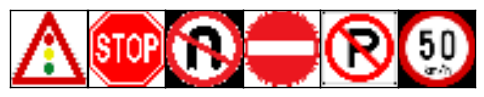

In [291]:
### Display the images in the form of a grid
def display_new(image_data, sample_size, n_labels):
    count = 0 #book keeping for plots

    fig = plt.figure(figsize=(sample_size, n_labels))
    grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)

    for x in range(sample_size):
        img = read_images[x]
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img) #, cmap='gray')
        fig.add_subplot(ax)
        count +=1


display_new(read_images, 6, 43)

In [292]:
test_data = np.array(read_images, dtype=np.uint8)

with open('new_test.p', 'wb') as test_file:
    pickle.dump(test_data, test_file)

with open('new_test.p', 'rb') as test_file:
    data = pickle.load(test_file)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

### Run the predictions here.
### Feel free to use as many code cells as needed.

In [300]:
data = np.array([normalize(image) for image in data], dtype=np.float32)

import tensorflow as tf

def flatten_images(images):
    imshape = images.shape
    features_count = imshape[1]*imshape[2]*imshape[3]
    return images.reshape(-1, features_count)

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    X_new_image = flatten_images(data)
    feed_dict_new = {x: X_new_image, drop_prob: 1.0}
    
    new_preds = session.run(y_pred, feed_dict=feed_dict_new)

features_count =  3072


In [301]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    can_5 = session.run(tf.nn.top_k(tf.constant(new_preds), k=5))

print("can_5 = ", can_5)

can_5 =  TopKV2(values=array([[ 0.03021867,  0.02769086,  0.02709941,  0.02705221,  0.02652373],
       [ 0.02992339,  0.02873607,  0.02726786,  0.02668327,  0.02663995],
       [ 0.03071024,  0.02861852,  0.02796547,  0.027085  ,  0.02651933],
       [ 0.02969954,  0.02768448,  0.02681963,  0.02679022,  0.02662735],
       [ 0.03078919,  0.02797982,  0.02767647,  0.0268658 ,  0.02677267],
       [ 0.03022229,  0.02799156,  0.02755829,  0.02697315,  0.02689189]], dtype=float32), indices=array([[32, 19, 21,  7,  3],
       [32, 19, 21, 27,  7],
       [32, 19, 21,  7, 27],
       [32, 19,  7,  3, 21],
       [32, 19, 21,  7, 27],
       [32, 19, 21,  7,  3]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.